In [3]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.real_data import Metrics, Vectors 

import sklearn
from sklearn.metrics import roc_curve, auc
import pandas as pd
from supervenn import supervenn

from scipy.stats import bernoulli, spearmanr

from operator import xor

import os



In [4]:

# # Define the test cases
# test_cases = [
#     {"y_true": [0, 1, 0, 1, 0], "y_pred": [0, 1, 1, 1, 0]},
#     {"y_true": [1, 0, 1, 1, 0], "y_pred": [0, 0, 1, 0, 1]},
#     {"y_true": [1, 1, 1, 0, 0], "y_pred": [1, 1, 1, 1, 0]},
#     {"y_true": [0, 0, 0, 0, 0], "y_pred": [1, 1, 1, 1, 1]},
#     {"y_true": [1, 1, 1, 1, 1], "y_pred": [0, 0, 0, 0, 0]},
# ]

# # Define the noise transition matrix
# T = np.array([[0.6, 0.4], 
#               [0.4, 0.6]])

# # Test the loss functions
# for i, test_case in enumerate(test_cases):
#     y_true = test_case["y_true"]
#     y_pred = test_case["y_pred"]

#     print(f"Test Case {i + 1}:")
#     print(f"y_true: {y_true}")
#     print(f"y_pred: {y_pred}")

#     # Instance 0-1 loss
#     batch_loss, instance_losses = instance_01loss(y_true, y_pred)
#     print(f"Instance 0-1 Loss: {instance_losses}")

#     # Natarajan Unbiased 0-1 loss
#     batch_loss, instance_losses, batch_loss_binary, instance_losses_binary = natarajan_unbiased_01_loss(y_true, y_pred, T)
#     print(f"Natarajan Unbiased 0-1 Loss:  Instance Losses = {instance_losses}, Instance Binary Losses = {instance_losses_binary}")

#     # Instance Forward 0-1 loss
#     y_probs = np.array([y_pred, 1 - np.array(y_pred)]).T  # Convert y_pred to probabilities
#     batch_loss, instance_losses = instance_forward_01loss(y_true, y_probs, T)
#     print(f"Instance Forward 0-1 Loss:  Instance Losses = {instance_losses}")
    
#     print("\n" + "-"*50 + "\n")


In [5]:
from sklearn.metrics import accuracy_score
def compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_pred_train, instance_err_pred_test):
    # Convert inputs to numpy arrays
    group_train = np.asarray(group_train)
    group_test = np.asarray(group_test)
    instance_err_true_train = np.asarray(instance_err_true_train)
    instance_err_true_test = np.asarray(instance_err_true_test)
    instance_err_pred_train = np.asarray(instance_err_pred_train)
    instance_err_pred_test = np.asarray(instance_err_pred_test)
    
    def calculate_rates(group, instance_err_true, instance_err_pred):
        group_indices = np.where(group == val)[0]
        actual_positives = np.sum(instance_err_true[group_indices] == 1)
        actual_negatives = np.sum(instance_err_true[group_indices] == 0)
        
        false_positives = np.sum((instance_err_pred[group_indices] == 1) & (instance_err_true[group_indices] == 0))
        false_negatives = np.sum((instance_err_pred[group_indices] == 0) & (instance_err_true[group_indices] == 1))
        
        fpr = false_positives / actual_negatives if actual_negatives > 0 else None
        fnr = false_negatives / actual_positives if actual_positives > 0 else None
        
        return fpr, fnr
    
    def calculate_regret_rate(group, instance_err_true, instance_err_pred):
        group_indices = np.where(group == val)[0]
        regret_in_group = np.sum(instance_err_true[group_indices] != instance_err_pred[group_indices])
        total_in_group = len(group_indices)
        return regret_in_group / total_in_group if total_in_group > 0 else 0.0
    
    # Calculate rates for training set
    fpr_train, fnr_train = calculate_rates(group_train, instance_err_true_train, instance_err_pred_train)
    fpr_test, fnr_test = calculate_rates(group_test, instance_err_true_test, instance_err_pred_test)
    
    # Calculate regret rates
    regret_train = calculate_regret_rate(group_train, instance_err_true_train, instance_err_pred_train)
    regret_test = calculate_regret_rate(group_test, instance_err_true_test, instance_err_pred_test)
    
    return {
        'fpr_train': fpr_train,
        'fnr_train': fnr_train,
        'fpr_test': fpr_test,
        'fnr_test': fnr_test,
        'regret_train': regret_train,
        'regret_test': regret_test
    }

class MetricsCalculator:
    def __init__(self, vectors):
        self.vectors = vectors
        self.metrics = Metrics()

    def calculate_metrics(self, draw_id):
        instance_err_true_train = self.vectors.get_vector("metadata", draw_id, "instance_err_true_train") #True 01 Error Train
        instance_err_true_test = self.vectors.get_vector("metadata", draw_id, "instance_err_true_test") #True 01 Error Test
        
        self.metrics.add_metric("metadata", draw_id, "clean_acc_train", 1-np.mean(instance_err_true_train))
        self.metrics.add_metric("metadata", draw_id, "clean_acc_test", 1-np.mean(instance_err_true_test))
        
        dataset = self.vectors.get_vector("metadata", draw_id, "dataset")
        T = self.vectors.get_vector("metadata", draw_id, "T")
        yn_train = self.vectors.get_vector("metadata", draw_id, "yn_train")
        train_preds = self.vectors.get_vector("metadata", draw_id, "train_preds")
        test_preds = self.vectors.get_vector("metadata", draw_id, "test_preds")
        train_probs = self.vectors.get_vector("metadata", draw_id, "train_probs")
        test_probs = self.vectors.get_vector("metadata", draw_id, "test_probs")
        y_train = self.vectors.get_vector("metadata", draw_id, "y_train")
        y_test = self.vectors.get_vector("metadata", draw_id, "y_test")

        disagreement_train = self.vectors.get_vector("metadata", draw_id, "disagreement_train")
        ambiguity_train = self.vectors.get_vector("metadata", draw_id, "ambiguity_train")
        
        disagreement_test = self.vectors.get_vector("metadata", draw_id, "disagreement_test")
        ambiguity_test = self.vectors.get_vector("metadata", draw_id, "ambiguity_test")
        
        disagreement_train = np.clip(disagreement_train, 0, 1)
        ambiguity_train = np.clip(ambiguity_train, 0, 1)
        disagreement_test = np.clip(disagreement_test, 0, 1)
        ambiguity_test = np.clip(ambiguity_test, 0, 1)

        #noise_level = T[0,1]

        #empirical_regret_estimate_train = (ambiguity_train +ambiguity_train)*(1-2*noise_level)+2*np.multiply(ambiguity_train, ambiguity_train)*(2*noise_level-1)+noise_level
        #empirical_regret_estimate_test = (ambiguity_test +ambiguity_test)*(1-2*noise_level)+2*np.multiply(ambiguity_test, ambiguity_test)*(2*noise_level-1)+noise_level

        empirical_regret_train_ours = np.mean(ambiguity_train) #sum_xy regret = empirical regret estimate
        plausible_instance_err_anticipated_train = (ambiguity_train > 0.).astype(int) #placeholder

        empirical_regret_test_ours = np.mean(ambiguity_test) #sum_xy regret = empirical regret estimate
        plausible_instance_err_anticipated_test = (ambiguity_test > 0.).astype(int) #placeholder
        
        self.metrics.add_metric("metadata", draw_id, "plausible_regret_train", np.mean(ambiguity_train))
        
        for err_method in ["01", "forward", "backward"]:
            if err_method == "01":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_01loss(yn_train, train_preds)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_01loss(y_test, test_preds)
                
            elif err_method == "forward":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_forward_01loss(yn_train, train_probs, T)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_forward_01loss(y_test, test_probs, T)
                
            elif err_method == "backward":
                _, _, pop_err_anticipated_train, instance_err_anticipated_train = natarajan_unbiased_01_loss(yn_train, train_preds, T)
                _, _, pop_err_anticipated_test, instance_err_anticipated_test = natarajan_unbiased_01_loss(y_test, test_preds, T)
                
                
            empirical_regret_train, regret_instances_train = instance_01loss(instance_err_true_train, instance_err_anticipated_train)
            fpr_train, fp_train, fnr_train, fn_train = regret_FPR_FNR(instance_err_true_train, instance_err_anticipated_train)
            
            
            empirical_regret_test, regret_instances_test = instance_01loss(instance_err_true_test, instance_err_anticipated_test)
            fpr_test, fp_test, fnr_test, fn_test = regret_FPR_FNR(instance_err_true_test, instance_err_anticipated_test)
            
            plausible_fpr_train, plausible_fp_train, plausible_fnr_train, plausible_fn_train = regret_FPR_FNR(regret_instances_train, plausible_instance_err_anticipated_train)
            plausible_fpr_test, plausible_fp_test, plausible_fnr_test, plausible_fn_test = regret_FPR_FNR(regret_instances_test, plausible_instance_err_anticipated_test)
            
        
            self.metrics.add_metric(err_method, draw_id, "pop_err_anticipated_train", np.mean(instance_err_anticipated_train)) #average noisy 01loss
            self.metrics.add_metric(err_method, draw_id, "pop_err_true_train", np.mean(instance_err_true_train)) #average clean 01loss
            self.metrics.add_metric(err_method, draw_id, "pop_err_true_test", np.mean(instance_err_true_test)) #average clean 01loss
            
            self.metrics.add_metric(err_method, draw_id, "delta_pop_err_train", (np.mean(instance_err_anticipated_train) - np.mean(instance_err_true_train))) #average clean 01loss
            
            self.metrics.add_metric(err_method, draw_id, "actual_regret_train", empirical_regret_train)
            
            #How well ambiguity flags regretful instances
            self.metrics.add_metric("metadata", draw_id, "coverage_regret_train", np.logical_and(plausible_instance_err_anticipated_train, regret_instances_train).sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            #self.metrics.add_metric("metadata", draw_id, "coverage_regret_train", accuracy_score(regret_instances_train, plausible_instance_err_anticipated_train)
            
            fp_indices_train = ((instance_err_anticipated_train == 1) & (instance_err_true_train == 0))
            fn_indices_train = ((instance_err_anticipated_train == 0) & (instance_err_true_train == 1))
            
            indices_regret = np.logical_or(fp_indices_train, fn_indices_train)
            
            self.metrics.add_metric("metadata", draw_id, "actual_regret_fpr_train",  fp_indices_train.sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            self.metrics.add_metric("metadata", draw_id, "actual_regret_fnr_train", fn_indices_train.sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            
            #FPR and FNR of plausible's ability to detect Regretful instances
            fp_indices_train = ((plausible_instance_err_anticipated_train == 1) & (regret_instances_train == 0))
            fn_indices_train = ((plausible_instance_err_anticipated_train == 0) & (regret_instances_train == 1))
                                    
            self.metrics.add_metric("metadata", draw_id, "plausible_regret_fpr_train",  fp_indices_train.sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            self.metrics.add_metric("metadata", draw_id, "plausible_regret_fnr_train", fn_indices_train.sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            
            regret_indices_train = np.where(regret_instances_train == 1)[0]
            regret_indices_test = np.where(regret_instances_test == 1)[0]
            
            #self.metrics.add_metric(err_method, draw_id, "actual_regret_fpr_train", fpr_train)
            #self.metrics.add_metric(err_method, draw_id, "actual_regret_fnr_train", fnr_train)
            #self.metrics.add_metric("metadata", draw_id, "plausible_regret_fpr_train", plausible_fpr_train)
            #self.metrics.add_metric("metadata", draw_id, "plausible_regret_fnr_train", plausible_fnr_train)

            self.metrics.add_metric(err_method, draw_id, "regret_instances_train", regret_instances_train)
            self.metrics.add_metric(err_method, draw_id, "ambiguity_train", ambiguity_train)
            self.metrics.add_metric(err_method, draw_id, "probs_train", train_probs)
            
            groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
            for group in groups:
                
                # Load the dataset splits and group labels
                _, _, _, _, group_train, group_test = load_dataset_splits(dataset, group)
                
                for val in np.unique(group_train):
                    group_stats = compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                    self.metrics.add_metric(err_method, draw_id, f"fpr_train_{group}_{val}", group_stats["fpr_train"])
                    #self.metrics.add_metric(err_method, draw_id, f"fpr_test_{group}_{val}", group_stats["fpr_test"])
                    self.metrics.add_metric(err_method, draw_id, f"fnr_train_{group}_{val}", group_stats["fnr_train"])
                    #self.metrics.add_metric(err_method, draw_id, f"fnr_test_{group}_{val}", group_stats["fnr_test"])

                    self.metrics.add_metric(err_method, draw_id, f"regret_train_{group}_{val}", group_stats["regret_train"])
            for c in [0,1]:
                
                class_stats = compute_group_stats(c, y_train, y_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                self.metrics.add_metric(err_method, draw_id, f"actual_regret_fpr_class_{c}_train", class_stats["fpr_train"])
                #self.metrics.add_metric(err_method, draw_id, f"fpr_test_{group}_{val}", group_stats["fpr_test"])
                self.metrics.add_metric(err_method, draw_id, f"actual_regret_fnr_class_{c}_train", class_stats["fnr_train"])
                #self.metrics.add_metric(err_method, draw_id, f"fnr_test_{group}_{val}", group_stats["fnr_test"])
                self.metrics.add_metric(err_method, draw_id, f"actual_regret_class_{c}_train", class_stats["regret_train"])
                
                class_stats = compute_group_stats(c, y_train, y_test, regret_instances_train, regret_instances_test, plausible_instance_err_anticipated_train, plausible_instance_err_anticipated_test)
                self.metrics.add_metric(err_method, draw_id, f"plausible_regret_fpr_class_{c}_train", class_stats["fpr_train"])
                self.metrics.add_metric(err_method, draw_id, f"plausible_regret_fnr_class_{c}_train", class_stats["fnr_train"])
                
                self.metrics.add_metric(err_method, draw_id, f"plausible_regret_class_{c}_train", class_stats["regret_train"])
               
                
            # Visualize the binary arrays
            #self.visualize_binary_arrays(instance_err_true_train, instance_err_anticipated_train, err_method, draw_id)

    def get_metrics(self):
        return self.metrics

    def visualize_binary_arrays(self, true_array, anticipated_array, err_method, draw_id):
        df = pd.DataFrame({
            'True Error': true_array,
            'Anticipated Error': anticipated_array
        })

        plt.figure(figsize=(10, 2))
        sns.heatmap(df.T, cmap="viridis", cbar=False)
        plt.axhline(y=1, color='gray', linestyle='--') 
        plt.title(f'Comparison of True and Anticipated Errors\nMethod: {err_method}, Draw ID: {draw_id}')
        plt.xlabel('Index')
        plt.ylabel('Error Type')
        plt.show()


In [6]:
def load_vectors(dataset, model_type, noise_type, noise_level, training_loss, epsilon=0.1, misspecify="correct", fixed_class = None, fixed_noise = None):
    """
    Load the vectors data from the specified path.

    Parameters:
    - parent_dir (str): The parent directory path.
    - dataset (str): The dataset name.
    - model_type (str): The model type.
    - noise_type (str): The noise type.
    - misspecify (str): The misspecify parameter.
    - noise_level (str): The noise level.
    - epsilon (str): The epsilon value.

    Returns:
    - vectors: The loaded vectors data.
    """
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    files_path = os.path.join(parent_dir, "results", "regret", dataset, model_type, noise_type, misspecify)
    
    if noise_type == "class_independent":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{epsilon}_vectors.pkl")
    elif noise_type == "class_conditional":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{fixed_class}_{fixed_noise}_{epsilon}_vectors.pkl")

    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file at path {path} does not exist.")
    
    # Load the vectors data from the file
    with open(path, 'rb') as file:
        vectors = pkl.load(file)
    
    return vectors


In [7]:
dataset = "cshock_eicu"
noise_type = "class_independent"
model_type = "LR"
n_models = 2
n_draws = 1
max_iter = 10000

T = np.array([[0.6, 0.4],
              [0.4, 0.6]])

all_metrics = []

for training_loss in ["None"]:
    vectors = run_experiment(dataset, noise_type, model_type, n_models=n_models, max_iter=max_iter, training_loss=training_loss, T=T, n_draws = n_draws)
    
    metrics_calculator = MetricsCalculator(vectors)
    
    for draw_id in range(n_draws):
        metrics_calculator.calculate_metrics(draw_id)
        
    metrics = metrics_calculator.get_metrics()
    
    #

    for method in ["metadata", "01", "forward", "backward"]:
        for draw_id in range(n_draws):
             #Get all metric names dynamically
            all_metric_names = metrics.get_all_metrics(method, draw_id)
            for metric_name in all_metric_names:
                value = metrics.get_metric(method, draw_id, metric_name)
                if value is not None:
                    all_metrics.append({
                        "training_loss": training_loss,
                        "err_method": method,
                        "draw_id": draw_id,
                        "metric_name": metric_name,
                        "value": value
                    })



  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
# Create a DataFrame from the collected metrics
metrics_df = pd.DataFrame(all_metrics)
metrics_df[metrics_df["metric_name"]== "actual_regret_train"]


,training_loss,err_method,draw_id,metric_name,value
12,None,01,0,actual_regret_train,0.404124
44,None,forward,0,actual_regret_train,0.404124
76,None,backward,0,actual_regret_train,0.404124


# Load Data

In [9]:
dataset = "cshock_eicu"
model_type = "LR"
noise_type = "class_conditional"
fixed_class = 0
fixed_noise = 0.0
misspecify = "correct"

all_metrics = []

for dataset in ["cshock_eicu_imbalanced", "cshock_mimic_imbalanced", "cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer", "saps_imbalanced", "support_imbalanced", "lungcancer_imbalanced"]:
    for model_type in ["LR", "NN"]:
        for noise_type in ["class_independent", "class_conditional"]:
            for noise_level in [0.0, 0.01, 0.05, 0.2, 0.4]:
                for training_loss in ["None", "backward", "forward"]:
                    try:
                        vectors = load_vectors(dataset, model_type, noise_type, noise_level=noise_level, training_loss = training_loss, fixed_noise=fixed_noise, fixed_class= fixed_class)
                    except Exception as e:
                        print(e)

                    metrics_calculator = MetricsCalculator(vectors)

                    for draw_id in range(5):
                        metrics_calculator.calculate_metrics(draw_id)

                    metrics = metrics_calculator.get_metrics()

                    
                    groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
                   
                    
                    if training_loss == "None":
                        method_lis = ["metadata", "01"]
                    else:
                        method_lis =  ["metadata"] +[training_loss]
                        
                    #method_lis =  ["metadata", "01"]
                    
                    for method in method_lis:
                        for draw_id in range(5):
                             #Get all metric names dynamically
                            all_metric_names = metrics.get_all_metrics(method, draw_id)
                            for metric_name in all_metric_names:

                                value = metrics.get_metric(method, draw_id, metric_name)

                                if value is not None and metric_name != "regret_indices_train" and not isinstance(value, np.ndarray):
                                   
                                    all_metrics.append({
                                        "dataset": dataset,
                                        "model_type": model_type,
                                        "noise_type": noise_type,
                                        "noise_level": noise_level,
                                        "training_loss": training_loss,
                                        "err_method": method, #ignore err_method column for now
                                        "draw_id": draw_id,
                                        "metric_name": metric_name,
                                        "value": value
                                    })



The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/None_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/backward_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/forward_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/None_0.01_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/backward_0.01_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/LR/class_independent/correct/forward_0.01_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalan

The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/forward_0.05_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/None_0.2_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/backward_0.2_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/forward_0.2_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/None_0.4_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snagaraj/results/regret/support_imbalanced/NN/class_conditional/correct/backward_0.4_0_0.0_0.1_vectors.pkl does not exist.
The file at path /scratch/hdd001/home/snaga

In [10]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv('all_results.csv', index=False)
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu_imbalanced,LR,class_independent,0.0,None,metadata,0,clean_acc_train,0.811627
1,cshock_eicu_imbalanced,LR,class_independent,0.0,None,metadata,0,clean_acc_test,0.823661
2,cshock_eicu_imbalanced,LR,class_independent,0.0,None,metadata,0,plausible_regret_train,0.184461
3,cshock_eicu_imbalanced,LR,class_independent,0.0,None,metadata,0,coverage_regret_train,0.000000
4,cshock_eicu_imbalanced,LR,class_independent,0.0,None,metadata,0,actual_regret_fpr_train,0.000000
...,...,...,...,...,...,...,...,...,...
109546,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,4,actual_regret_fnr_class_1_train,0.412137
109547,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,4,actual_regret_class_1_train,0.412137
109548,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,4,plausible_regret_fpr_class_1_train,1.000000
109549,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,4,plausible_regret_fnr_class_1_train,1.000000


In [11]:
metrics_df.metric_name.unique()

array(['clean_acc_train', 'clean_acc_test', 'plausible_regret_train',
       'coverage_regret_train', 'actual_regret_fpr_train',
       'actual_regret_fnr_train', 'plausible_regret_fpr_train',
       'plausible_regret_fnr_train', 'pop_err_anticipated_train',
       'pop_err_true_train', 'pop_err_true_test', 'delta_pop_err_train',
       'actual_regret_train', 'fpr_train_age_0', 'fnr_train_age_0',
       'regret_train_age_0', 'fpr_train_age_1', 'fnr_train_age_1',
       'regret_train_age_1', 'fpr_train_sex_0', 'fnr_train_sex_0',
       'regret_train_sex_0', 'fpr_train_sex_1', 'fnr_train_sex_1',
       'regret_train_sex_1', 'actual_regret_fpr_class_0_train',
       'actual_regret_fnr_class_0_train', 'actual_regret_class_0_train',
       'plausible_regret_fpr_class_0_train',
       'plausible_regret_class_0_train',
       'actual_regret_fpr_class_1_train',
       'actual_regret_fnr_class_1_train', 'actual_regret_class_1_train',
       'plausible_regret_fpr_class_1_train',
       'plausibl

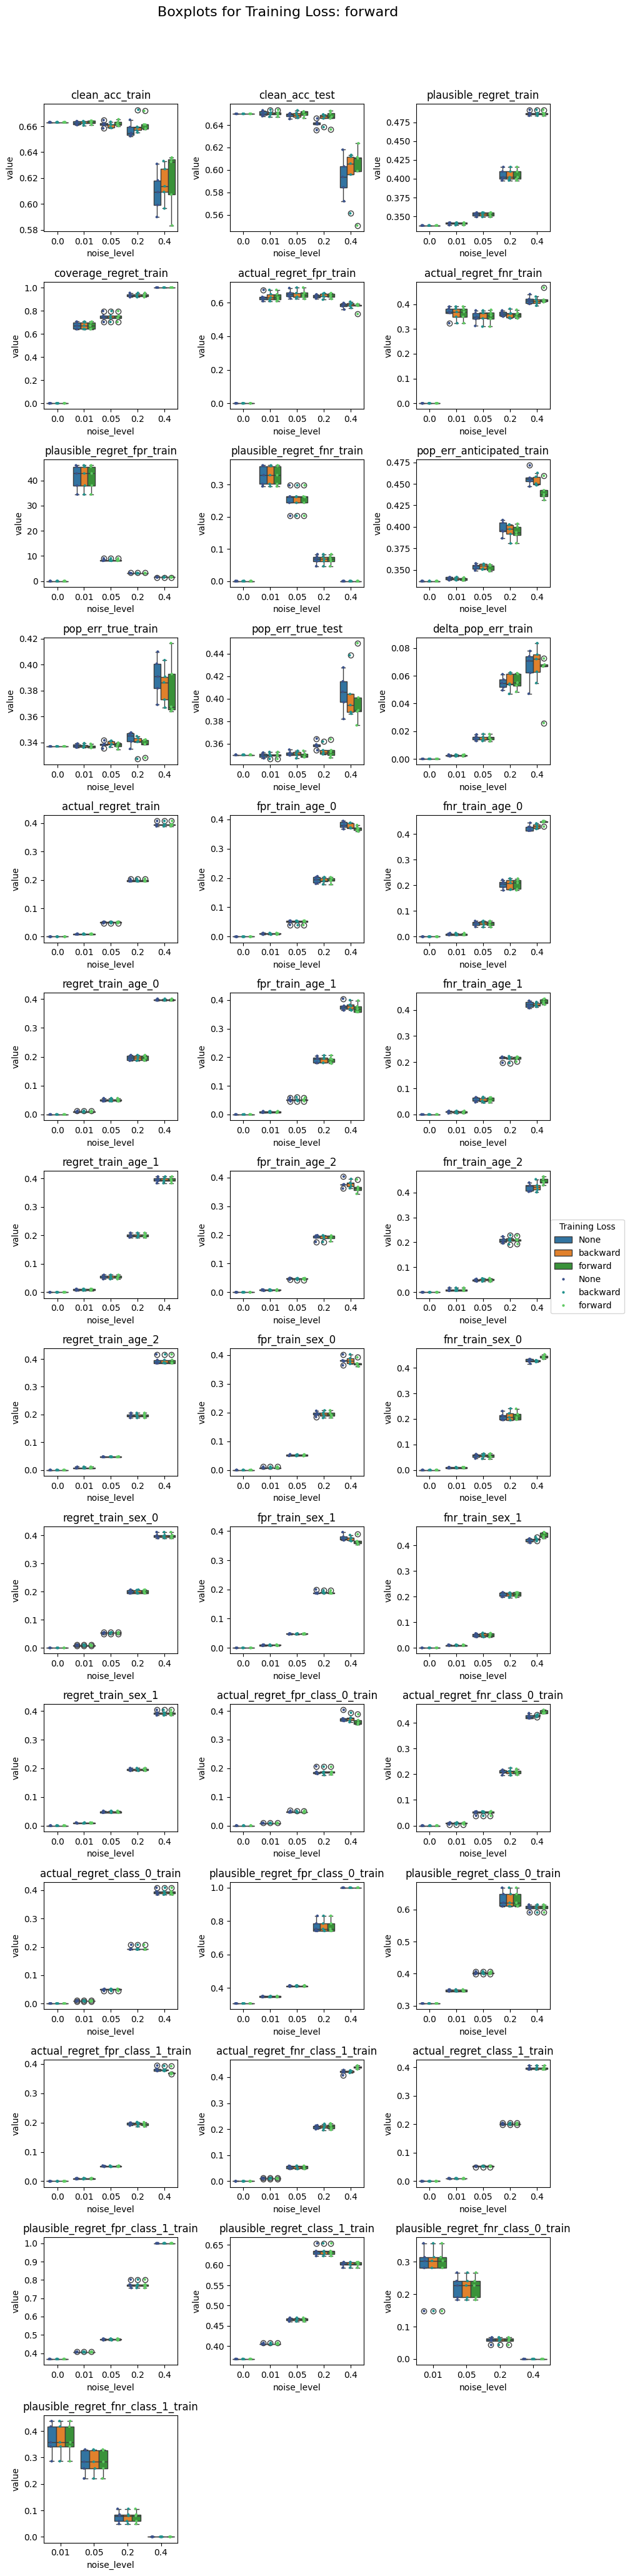

In [12]:
def create_boxplot(df, metric_names, ncols=3):
    nrows = (len(metric_names) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharey=False)
    fig.suptitle(f'Boxplots for Training Loss: {training_loss}', fontsize=16)
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, metric_name in enumerate(metric_names):
        sns.boxplot(ax=axs[i], x='noise_level', y='value', hue='training_loss', data=df[df['metric_name'] == metric_name], dodge=True)
        sns.stripplot(ax=axs[i], x='noise_level', y='value', hue='training_loss', data=df[df['metric_name'] == metric_name], 
                      dodge=True, marker='o', s = 3,alpha=1, palette='viridis')
        
    
        #axs[i].set_ylim(0, 1.0)
            
        axs[i].set_title(f'{metric_name}')
        
        # Remove the duplicate legends from the stripplot
        if i == 0:
            handles, labels = axs[i].get_legend_handles_labels()
            fig.legend(handles, labels, title='Training Loss', bbox_to_anchor=(1.05, 0.5), loc='center')
        axs[i].legend_.remove()

    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title and legend
    plt.show()


model_type = "LR"
noise_type = "class_independent"
dataset = "support"

sub_df = metrics_df[(metrics_df["model_type"]==model_type) & (metrics_df["noise_type"]==noise_type)& (metrics_df["dataset"]==dataset)]

metric_names = sub_df.metric_name.unique()

create_boxplot(sub_df, metric_names)


# Estimating regret 

In [13]:
dataset = "cshock_eicu"
model_type = "LR"
noise_type = "class_conditional"
fixed_class = 0
fixed_noise = 0.0
misspecify = "correct"

all_metrics = []


for dataset in ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]:
    for model_type in ["LR", "NN"]:
        for noise_type in ["class_independent", "class_conditional"]:
            for noise_level in [0.0, 0.01, 0.05, 0.2, 0.4]:
                for training_loss in ["None", "backward", "forward"]:
                    try:
                        vectors = load_vectors(dataset, model_type, noise_type, noise_level=noise_level, training_loss = training_loss, fixed_noise=fixed_noise, fixed_class= fixed_class)
                    except Exception as e:
                        print(e)

                    metrics_calculator = MetricsCalculator(vectors)

                    for draw_id in range(5):
                        metrics_calculator.calculate_metrics(draw_id)

                    metrics = metrics_calculator.get_metrics()

                    groups = ["age", "hiv"] if dataset == "saps" else ["age", "sex"]

                    
                    if training_loss == "None":
                        method_lis = ["metadata", "01"]
                    else:
                        method_lis =  ["metadata"] +[training_loss]
                        
                    method_lis =  ["metadata", "01"]
                    
                    for method in method_lis:
                        for draw_id in range(5):
                             #Get all metric names dynamically
                            all_metric_names = metrics.get_all_metrics(method, draw_id)
                            for metric_name in all_metric_names:

                                value = metrics.get_metric(method, draw_id, metric_name)

                                if value is not None and (metric_name == "regret_instances_train" or metric_name == "ambiguity_train" or metric_name == "probs_train"):
                                    all_metrics.append({
                                        "dataset": dataset,
                                        "model_type": model_type,
                                        "noise_type": noise_type,
                                        "noise_level": noise_level,
                                        "training_loss": training_loss,
                                        #"err_method": method, #ignore err_method column for now
                                        "draw_id": draw_id,
                                        "metric_name": metric_name,
                                        "value": value
                                    })



In [14]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,draw_id,metric_name,value
0,cshock_eicu,LR,class_independent,0.0,None,0,regret_instances_train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,cshock_eicu,LR,class_independent,0.0,None,0,ambiguity_train,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,cshock_eicu,LR,class_independent,0.0,None,0,probs_train,"[[0.57467145, 0.4253285], [0.6601399, 0.339860..."
3,cshock_eicu,LR,class_independent,0.0,None,1,regret_instances_train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,cshock_eicu,LR,class_independent,0.0,None,1,ambiguity_train,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
4495,lungcancer,NN,class_conditional,0.4,forward,3,ambiguity_train,"[1.0, 0.02, 1.0, 0.01, 1.0, 0.01, 0.0, 0.0, 0...."
4496,lungcancer,NN,class_conditional,0.4,forward,3,probs_train,"[[0.7230841, 0.27691588], [0.46093673, 0.53906..."
4497,lungcancer,NN,class_conditional,0.4,forward,4,regret_instances_train,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4498,lungcancer,NN,class_conditional,0.4,forward,4,ambiguity_train,"[0.0, 0.97, 0.0, 0.01, 1.0, 0.99, 0.0, 0.0, 0...."


/tmp/ipykernel_1152/4200989727.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
/tmp/ipykernel_1152/4200989727.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(y)) + '%' if y == 100 else str(int(y))+"  " for y in ax.get_yticks()])


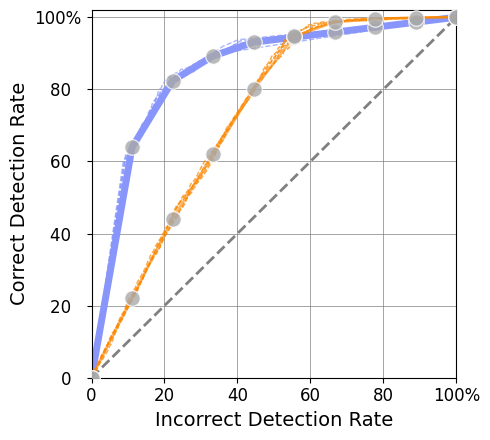

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
# Initialize a list of bright colors for the datasets and comparisons
bright_colors = ["#8896FB", "#fc8803"]  # Orange for ambiguity, Blue for probs
comparison_labels = ['Ambiguity Rates', 'Predicted Probabilities']


# Plot ROC curves with seaborn
for dataset in ["cshock_mimic"]:
    for noise_level in [0.4]:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Filter the DataFrame for the current criteria
        sub_df = metrics_df[
            (metrics_df["training_loss"] == "None") &
            (metrics_df["noise_level"] == noise_level) &
            (metrics_df["model_type"] == model_type) &
            (metrics_df["noise_type"] == noise_type) &
            (metrics_df["dataset"] == dataset)
        ]

        for comparison, label, color in zip(['ambiguity_train', 'probs_train'], comparison_labels, bright_colors):
            tprs = []
            mean_fpr = np.linspace(0, 1, 10)

            for draw_id in range(5):
                regret_values = sub_df[(sub_df["draw_id"] == draw_id) & (sub_df["metric_name"] == "regret_instances_train")]['value'].values[0]
                comparison_values = sub_df[(sub_df["draw_id"] == draw_id) & (sub_df["metric_name"] == comparison)]['value'].values[0]

                if len(regret_values) > 0 and len(comparison_values) > 0:
                    regret_values = np.array(regret_values)
                    comparison_values = np.array(comparison_values)
                    if comparison == 'probs_train':
                        comparison_values = comparison_values[:, 1]

                    fpr, tpr, _ = roc_curve(regret_values, comparison_values)
                    tprs.append(interp1d(fpr, tpr, kind='linear')(mean_fpr))

                    # Plot each draw ID separately with faint dashed lines
                    sns.lineplot(x=fpr*100, y=tpr*100, color=color, alpha=0.7, lw=1, linestyle='--', ax=ax)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            
            lw = 5 if comparison == "ambiguity_train" else 2
            alpha = 1 if comparison == "ambiguity_train" else 0.6
                
            # Plot the averaged ROC curve
            sns.lineplot(x=mean_fpr*100, y=mean_tpr*100, ax=ax,color=color, lw=lw, alpha=alpha, linestyle='-', label=f'{label} (AUC = {mean_auc:.2f})')

            # Scatter points at each knot
            sns.scatterplot(x=mean_fpr*100, y=mean_tpr*100,ax=ax, color="darkgray", s=125, zorder=5, alpha=0.8)

        ax.plot([0, 100], [0, 100], color='gray', lw=2, linestyle='--')
        ax.set_xlim(0,100)
        ax.set_ylim(0,102)
        ax.set_xlabel('Incorrect Detection Rate', fontsize=14)
        ax.set_ylabel('Correct Detection Rate', fontsize=14)
        # Set grey gridlines
        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        plt.tick_params(axis='both', which='major', labelsize=14)
        
        ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
        ax.set_yticklabels([str(int(y)) + '%' if y == 100 else str(int(y))+"  " for y in ax.get_yticks()])
        
        num_x_ticks = 6
        num_y_ticks = 6


        ax.set_xticks(np.linspace(0, 100, num_x_ticks))
        ax.set_yticks(np.linspace(0, 100, num_y_ticks))
    

        # Remove the legend
        ax.get_legend().remove()
       

        # Set grey gridlines
        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)

        # Customize major and minor ticks and their labels
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=10)



        # Adjust layout to make space for the legend
        plt.tight_layout(rect=[0, 0.1, 1, 1])
        plt.savefig("roc.pdf", bbox_inches='tight')
        plt.show()


# 